Boston prediction by Multilayerperceptron

In [77]:
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.layers as layers

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

def get_boston_dataframe():
    '''
    returns boston dataset as pandas dataframe,
    labels are in target column
    '''
    boston = datasets.load_boston()
    df = pd.DataFrame(boston.data, columns = boston.feature_names)
    df['target'] = boston.target
    return df

def get_corr(df):
    '''
    returns correlation matrix from pandas dataframe
    few notes to sort correlation you can use:
    corr = get_corr(df)
    corr.unstack().abs().sorted_values()
    corr['column name'].abs().sorted_values()
    
    args:
      df: <pandas.core.frame.DataFrame>
    '''
    return df.corr(method =  'pearson')

def plot_correlation(corr_matrix):
    '''
    will plot heatmap based on values in correlation matrix
    
    args:
      corr_matrix: <pandas.core.frame.DataFrame>
    '''
    fig, axes = plt.subplots( figsize = corr_matrix.shape)
    cmap = sns.diverging_palette( 220, 10, as_cmap = True)
    _ = sns.heatmap( corr_matrix, cmap = cmap, square = True, cbar_kws = {'shrink': .9}, ax = axes, annot = True, annot_kws = {'fontsize':12})
    
def get_normalized_dataset(dataframe, columns_names = ['RM','LSTAT','PTRATIO'], labels = 'target'):
    '''
    split data frame to train and test x, y also normalize it
    
    how to use:
      X_train, X_test, Y_train, Y_test = get_normalized_dataset(df)
    
    args:
      dataframe: <pandas.core.frame.DataFrame>
      columns_names: <list>, list of column names which can be obtained from get_corr(df)['column name'].abs().sorted_values() - most positively or negatively correlated columns
      labels: <string>, name of column, where are labels values stored
    '''
    train_and_test = train_test_split(df[columns_names], df[[labels]], test_size = 0.3, random_state = 0)
    for i, v in enumerate(train_and_test):
        train_and_test[i] = MinMaxScaler().fit_transform(v)
    return train_and_test 

class NNModel():
    '''
    Multilayer Perceptron for price prediction
    '''
    
    def __init__(self, learning_rate = 0.01, shape = (3,1), n_hidden = 20):
        self.learning_rate = learning_rate
        self.shape = shape
        # placeholders
        self.X = tf.placeholder(tf.float32,[None, self.shape[0]], name = 'X')
        self.Y = tf.placeholder(tf.float32, name = 'Y')
        #layers
        self.fc1 = layers.fully_connected(self.X, n_hidden, activation_fn = tf.nn.relu)
        self.Y_hat = layers.fully_connected(self.fc1, self.shape[1], activation_fn = tf.sigmoid)
        #loss and optimization
        self.correct_prediction = tf.square(self.Y - self.Y_hat)
        self.loss = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32)) #mse
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        # for tensorboard
        self.loss_scalar = tf.summary.scalar('cross-entropy', self.loss)
        # inititialization and session stuff
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.Session()
        
    def fit(self, X, Y, epochs = 100, every = 10, folder = 'BostonNNLog', batch_size = 500, init = True ):
        '''
        optimizes weights
        args:
          X: <numpy.array>, features 
          Y: <numpy.array>, labels
          epochs: <int>, number of epochs
          every: <int>, how often print message with Epoch and Loss values
          folder: <string>, name of folder where to store data for TensorBoard
          batch_size: <int>, size of features array, size of features sample
        '''
        total = []
        if init:
            self.sess.run(self.init_op)
        summary_writer = tf.summary.FileWriter(folder, self.sess.graph)
        x_length = len(X)
        for i in range(epochs):
            batch = np.random.randint(0, x_length - batch_size, 1)[0]
            x_batch = X[batch:batch + batch_size]
            y_batch = Y[batch:batch + batch_size]
            _, l = self.sess.run([self.optimizer, self.loss], feed_dict = {self.X: x_batch, self.Y: y_batch})
            loss = self.sess.run(self.loss_scalar, feed_dict = {self.X: x_batch, self.Y: y_batch})
            summary_writer.add_summary(loss, i)
            total.append(l)
            if i % every == 0:
                print('[ {} ] Epoch {} Loss: {}'.format(time.ctime(), i, l))
        return total
    
    def predict(self, X, before_fit = False):
        '''
        return predicted values, 
        
        args:
          X: <numpy.array>, features
          before_fit: <boolean>, change to True if you want to use before calling fit method
        '''
        if before_fit:
            self.sess.run(self.init_op)
        Y_hat = self.sess.run(self.Y_hat, feed_dict = {self.X: X})
        return Y_hat
    
    def show(self, values):
        '''
        plot graph
        
        args:
          values: <list>, list or array of values to be plotted
        '''
        plt.plot(values)
        plt.show()
    
    def close_session(self):
        '''
        closes tensorflow session
        '''
        self.sess.close()
        return True
    
    def close_and_reset(self):
        '''
        closes tensorflow session, clears the default graph stack and resets the global default graph.
        '''
        self.sess.close()
        tf.reset_default_graph()
        return True


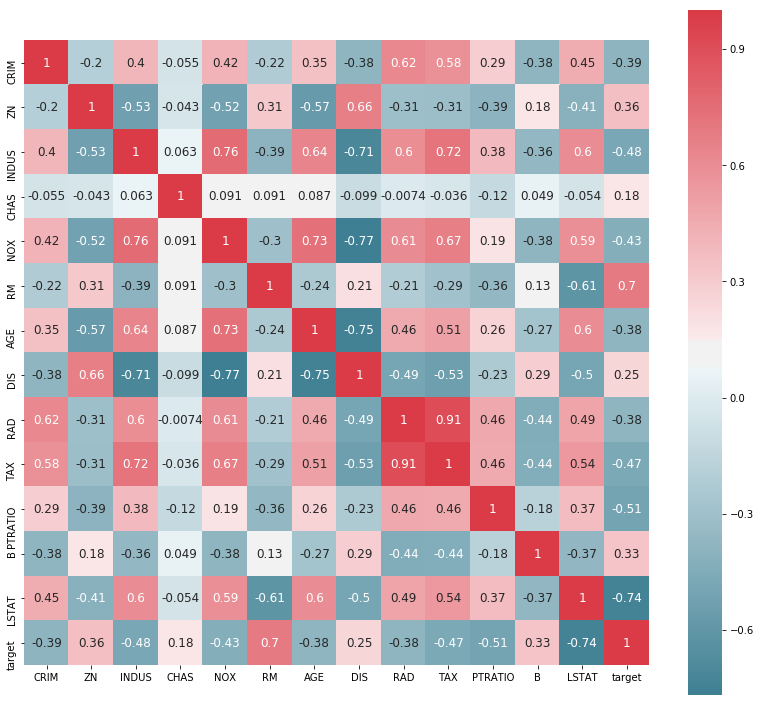

In [6]:
df = get_boston_dataframe()
corr = get_corr(df)
plot_correlation(corr)

In [65]:
X_train, X_test, Y_train, Y_test = get_normalized_dataset(df)

In [102]:
boston = NNModel(learning_rate = 0.0001)
before = boston.predict(X_train, before_fit = True) # prediction after random initialization of model, simply: random values
data = boston.fit(X_train, Y_train, epochs = 20000, every = 5000, batch_size = 300)

[ Wed Dec 26 17:16:22 2018 ] Epoch 0 Loss: 0.05790938809514046
[ Wed Dec 26 17:16:31 2018 ] Epoch 5000 Loss: 0.00978758092969656
[ Wed Dec 26 17:16:41 2018 ] Epoch 10000 Loss: 0.008271045051515102
[ Wed Dec 26 17:16:50 2018 ] Epoch 15000 Loss: 0.007605860009789467


In [103]:
test = boston.predict(X_train)

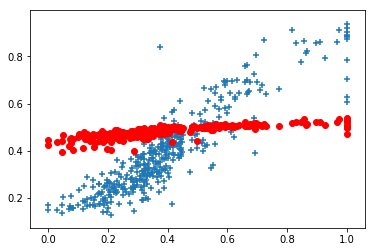

In [106]:
plt.scatter(Y_train, test, marker = '+')
plt.scatter(Y_train, before, c = 'red', marker= 'o')